In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from clim680_utils import latlonticks

## ENSO Analysis

#### This notebook will evaluate the effect of sea surface temperatures (SSTs) on soil moisture. The effect of El Niño and La Niña (ENSO) will be evaluated globally.

Datasets in use are the soil moisture dataset, described in other notebooks, and a SST dataset obtained from NOAA. The SST data consists of monthly SST data from a variety of sources including satellites and shipboard sensors. The database is created by the Japanese Meteorogical Agency (JMA). More information about the SST data can be found at:     https://www.psl.noaa.gov/data/gridded/data.cobe.html

In [2]:
sw = xr.open_dataset("/scratch/dklein3/soilw.mon.mean.v2.nc")
sst = xr.open_dataset("/scratch/dklein3/clim680/sst.mon.mean.nc")
sst

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1570)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2021-10-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

Reversing the latitudes of the SST database and shrinking the time frame to match the soil moisture data.

In [3]:
sst=sst.sel(time=slice(sw['time'][0],sw['time'][-1]))
sst=sst.reindex(lat=list(reversed(sst['lat'])))
sst

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 884)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

#### Creating a Niño3.4 anomaly index

In [4]:
nino34=sst.sel(lon=slice(360-170,360-120),lat=slice(-5,5))
nino34

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 50, time: 884)
Coordinates:
  * lat      (lat) float32 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float32 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

In [5]:
nino34index=nino34.mean(dim=['lat','lon'])
nino34index

<xarray.Dataset>
Dimensions:  (time: 884)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time) float32 26.6 26.63 27.39 27.68 ... 27.54 27.61 27.07 26.46

In [6]:
nino34climo=nino34index.groupby('time.month').mean()
nino34anom=nino34index.groupby('time.month') - nino34climo
nino34anom=nino34anom.drop_vars('month')
nino34anom

<xarray.Dataset>
Dimensions:  (time: 884)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    sst      (time) float32 0.09058 -0.07826 0.2168 ... -0.1389 -0.3504

#### Creating composite maps.

In [7]:
elnino=nino34anom['sst'].where(nino34anom['sst']>=1)
lanina=nino34anom['sst'].where(nino34anom['sst']<=-1)
neutral=nino34anom['sst'].where(np.logical_and(nino34anom['sst']>-1,nino34anom['sst']<1))
print('El Nino: ',elnino.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('La Nina: ',lanina.count(dim='time').values)

counts=[elnino.count(dim='time').values,
        lanina.count(dim='time').values,
        neutral.count(dim='time').values]
print(counts)

El Nino:  88
Neutral:  715
La Nina:  81
[array(88), array(81), array(715)]


Determining soil moisture anomalies.

In [8]:
sw_climo=sw.groupby('time.month').mean()
sw_anom=sw.groupby('time.month')-sw_climo
sw_anom

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 884)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 10 11 12 1 2 3 4 5 6 7 8
Data variables:
    soilw    (time, lat, lon) float32 nan nan nan nan ... 145.5 145.5 145.5

Determining the mean soil moisture anomaly during each condition of ENSO.

In [9]:
elnino_sw=sw_anom.sel(time=elnino.dropna(dim='time')['time']).mean(dim='time')
lanina_sw=sw_anom.sel(time=lanina.dropna(dim='time')['time']).mean(dim='time')
neutral_sw=sw_anom.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

comp_sw=[elnino_sw,lanina_sw,neutral_sw]
comp_sw

[<xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan nan ... 5.341 5.367 5.387 5.38,
 <xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan nan ... 4.14 4.133 4.128 4.131,
 <xarray.Dataset>
 Dimensions:  (lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
 Data variables:
     soilw    (lat, lon) float32 nan nan nan nan ... -1.139 -1.142 -1.143 -1.143]

Plotting the composite of soil moisture anomalies with all three ENSO conditions.

Text(0.5, 0.98, 'Composite Soil Moisture Anomalies during ENSO')

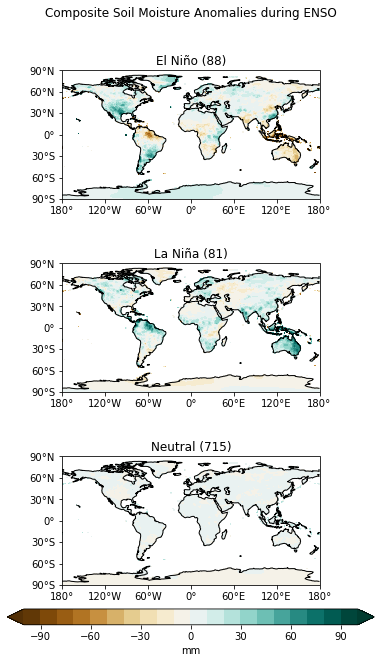

In [10]:
labels=['El Niño','La Niña', 'Neutral']
clevs=np.arange(-100,110,10)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over each condition and plot
for i,enso in enumerate(comp_sw):

        # Select the condition
        data=comp_sw[i]['soilw']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=comp_sw[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_sw[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the condition
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies during ENSO')

Determining and plotting the difference between soil moisture anomalies during different ENSO conditions.

In [11]:
diff_sw=[elnino_sw-neutral_sw, 
             lanina_sw-neutral_sw]

Text(0.5, 0.98, 'Composite Soil Moisture Differences during ENSO')

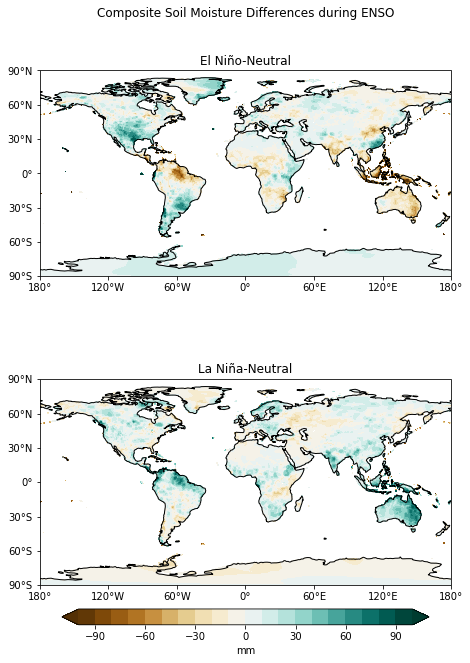

In [12]:
labels=['El Niño-Neutral','La Niña-Neutral']
clevs=np.arange(-100,110,10)

# Define the figure and each axis for the 2 rows and 1 column
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the conditions and plot
for i,enso in enumerate(diff_sw):

        # Select the condition
        data=diff_sw[i]['soilw']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=diff_sw[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,diff_sw[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the condition
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Differences during ENSO')

#### Evaluating the statistical significance of the composite plots.

In [13]:
p=0.05
from scipy.stats import ttest_ind

elnino_sw_vals=sw_anom.sel(time=elnino.dropna(dim='time')['time'])
lanina_sw_vals=sw_anom.sel(time=lanina.dropna(dim='time')['time'])
neutral_sw_vals=sw_anom.sel(time=neutral.dropna(dim='time')['time'])

tstat,pval=ttest_ind(elnino_sw_vals['soilw'], 
                neutral_sw_vals['soilw'], 
                equal_var = False)
mask_diff=diff_sw[0]['soilw'].where(pval<p)
mask_diff

<xarray.DataArray 'soilw' (lat: 360, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8

Plotting the soil moisture composite with El Niño with significance.

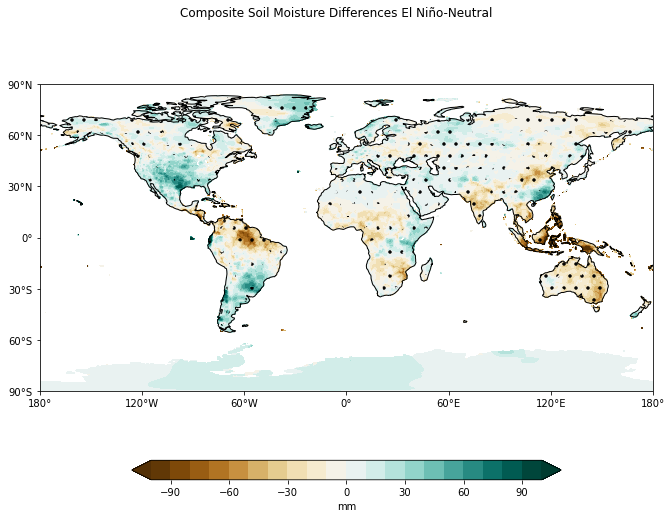

In [31]:
clevs=np.arange(-100,110,10)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
axs=plt.axes(projection=ccrs.PlateCarree())


data=diff_sw[0]['soilw']

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_sw[0]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_sw[0]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_sw[0]['lat'],data,clevs,
                    transform = ccrs.PlateCarree(),
                    cmap='BrBG',extend='both')

axs.contourf(lons,diff_sw[0]['lat'],mask_data,[0,1],
              transform = ccrs.PlateCarree(),colors='None',
             hatches=['.',''],extend='both',alpha=0)

# Draw the coastines for each subplot
axs.coastlines()

# Put in latitude and longitutde ticks
latlonticks(axs)
        
# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Differences El Niño-Neutral')
plt.savefig('elninocompsig.png')

Determining and plotting the soil moisture composite with El Niña with significance.

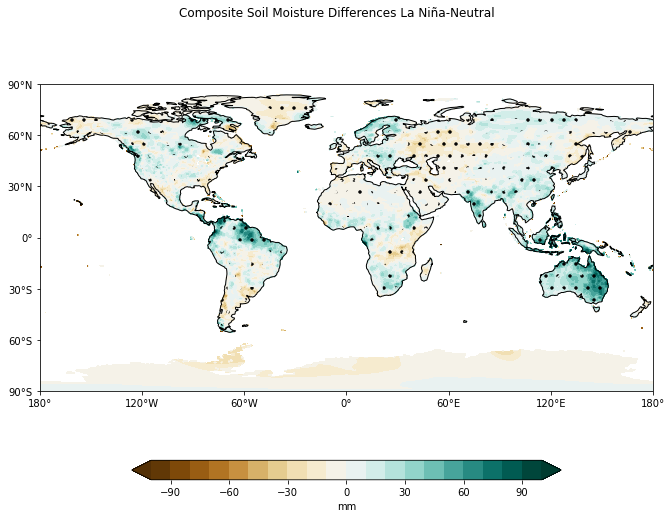

In [30]:
tstat,pval=ttest_ind(lanina_sw_vals['soilw'], 
                neutral_sw_vals['soilw'], 
                equal_var = False)
mask_diff=diff_sw[1]['soilw'].where(pval<p)

clevs=np.arange(-100,110,10)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
axs=plt.axes(projection=ccrs.PlateCarree())


data=diff_sw[1]['soilw']

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_sw[1]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_sw[1]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_sw[1]['lat'],data,clevs,
                    transform = ccrs.PlateCarree(),
                    cmap='BrBG',extend='both')

axs.contourf(lons,diff_sw[1]['lat'],mask_data,[0,1],
              transform = ccrs.PlateCarree(),colors='None',
             hatches=['.',''],extend='both',alpha=0)

# Draw the coastines for each subplot
axs.coastlines()

# Put in latitude and longitutde ticks
latlonticks(axs)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='mm')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Differences La Niña-Neutral')
plt.savefig('laninacompsig.png')

#### Determining the correlation and linear regression between ENSO and soil moisture.

In [16]:
from scipy.stats import linregress
lon=(len(sw_anom['lon']))
lat=(len(sw_anom['lat']))
m_array=np.zeros((lat,lon))
p_array=np.zeros((lat,lon))
r_array=np.zeros((lat,lon))
for i in range(lon):
    for j in range(lat):
        m_array[j,i], intercept, r_array[j,i], p_array[j,i], std_err = linregress(nino34anom['sst'], sw_anom['soilw'][:,j,i])
r_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Adjusting the significance for the number of data points

In [17]:
def fdr(p_vals):

    # from https://stackoverflow.com/questions/25185205/calculating-adjusted-p-values-in-python  
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [18]:
# function expecting vector so reshape 2D p value array as vector
p_array_vec=np.ravel(p_array, order='C')
p_array_corrected_vec=fdr(p_array_vec)
# reshape corrected p value vectore back to 2D array
p_array_corrected=np.reshape(p_array_corrected_vec, (360,720), order='C')
mask_sig2=np.where(p_array_corrected<0.05,r_array,np.nan)

#### Plotting the correlation between ENSO and soil moisture with significance.

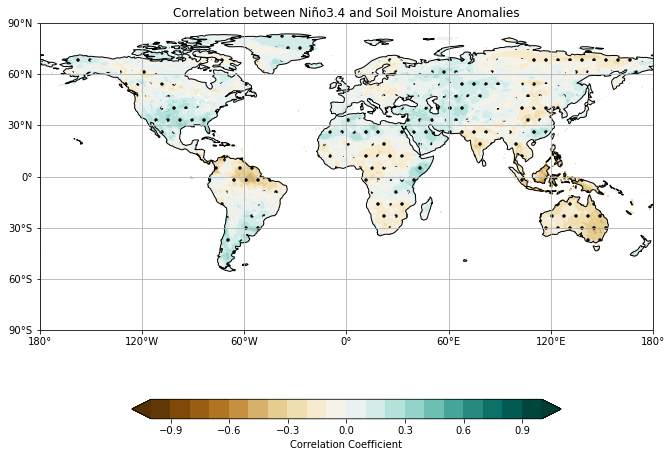

In [21]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=sw_anom['lon'])
mask_data,lons=add_cyclic_point(mask_sig2,coord=sw_anom['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,sw_anom['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='BrBG',extend='both')

ax.contourf(lon,sw_anom['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Put in latitude and longitutde ticks
latlonticks(ax)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Niño3.4 and Soil Moisture Anomalies')
plt.savefig('ensocorr.png')

#### Plotting the linear regression between ENSO and soil moisure.

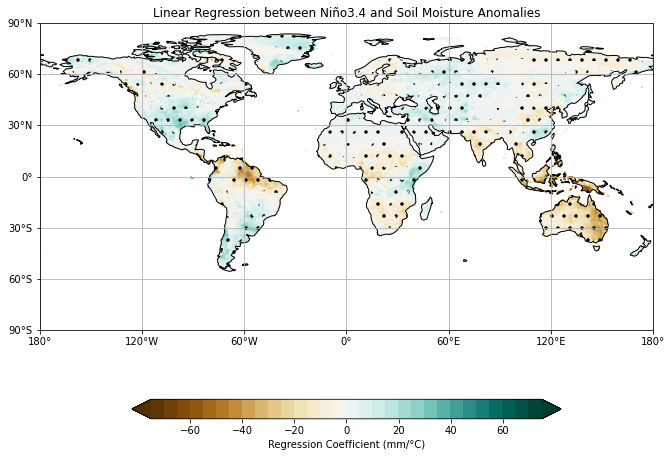

In [23]:
clevs=np.arange(-75,80,5)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=m_array
data,lon=add_cyclic_point(data,coord=sw_anom['lon'])
mask_data,lons=add_cyclic_point(mask_sig2,coord=sw_anom['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,sw_anom['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='BrBG',extend='both')

ax.contourf(lon,sw_anom['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Put in latitude and longitutde ticks
latlonticks(ax)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Regression Coefficient (mm/°C)')

# Add title
plt.title('Linear Regression between Niño3.4 and Soil Moisture Anomalies')
plt.savefig('ensolinreg.png')